DEEP EDA: PURCHASE ORDERS - THE MISSING PIECE?

[1] PURCHASE ORDERS DATASET STRUCTURE
--------------------------------------------------------------------------------
Total purchase orders: 33171
Columns: ['purchase_order_id', 'purchase_order_item_no', 'quantity', 'delivery_date', 'product_id', 'product_version', 'created_date_time', 'modified_date_time', 'unit_id', 'unit', 'status_id', 'status']

Sample:
   purchase_order_id  purchase_order_item_no  quantity       delivery_date  product_id  product_version   created_date_time                  modified_date_time  unit_id unit  status_id  status
0                  1                       1     -14.0 2003-05-11 22:00:00    91900143                1 2003-05-12 10:00:48  2004-06-15 06:16:18.0000000 +00:00      NaN  NaN          2  Closed
1                 22                       1   23880.0 2003-05-26 22:00:00    91900160                1 2003-05-27 12:42:07  2012-06-29 09:41:13.0000000 +00:00      NaN  NaN          2  Closed
2           

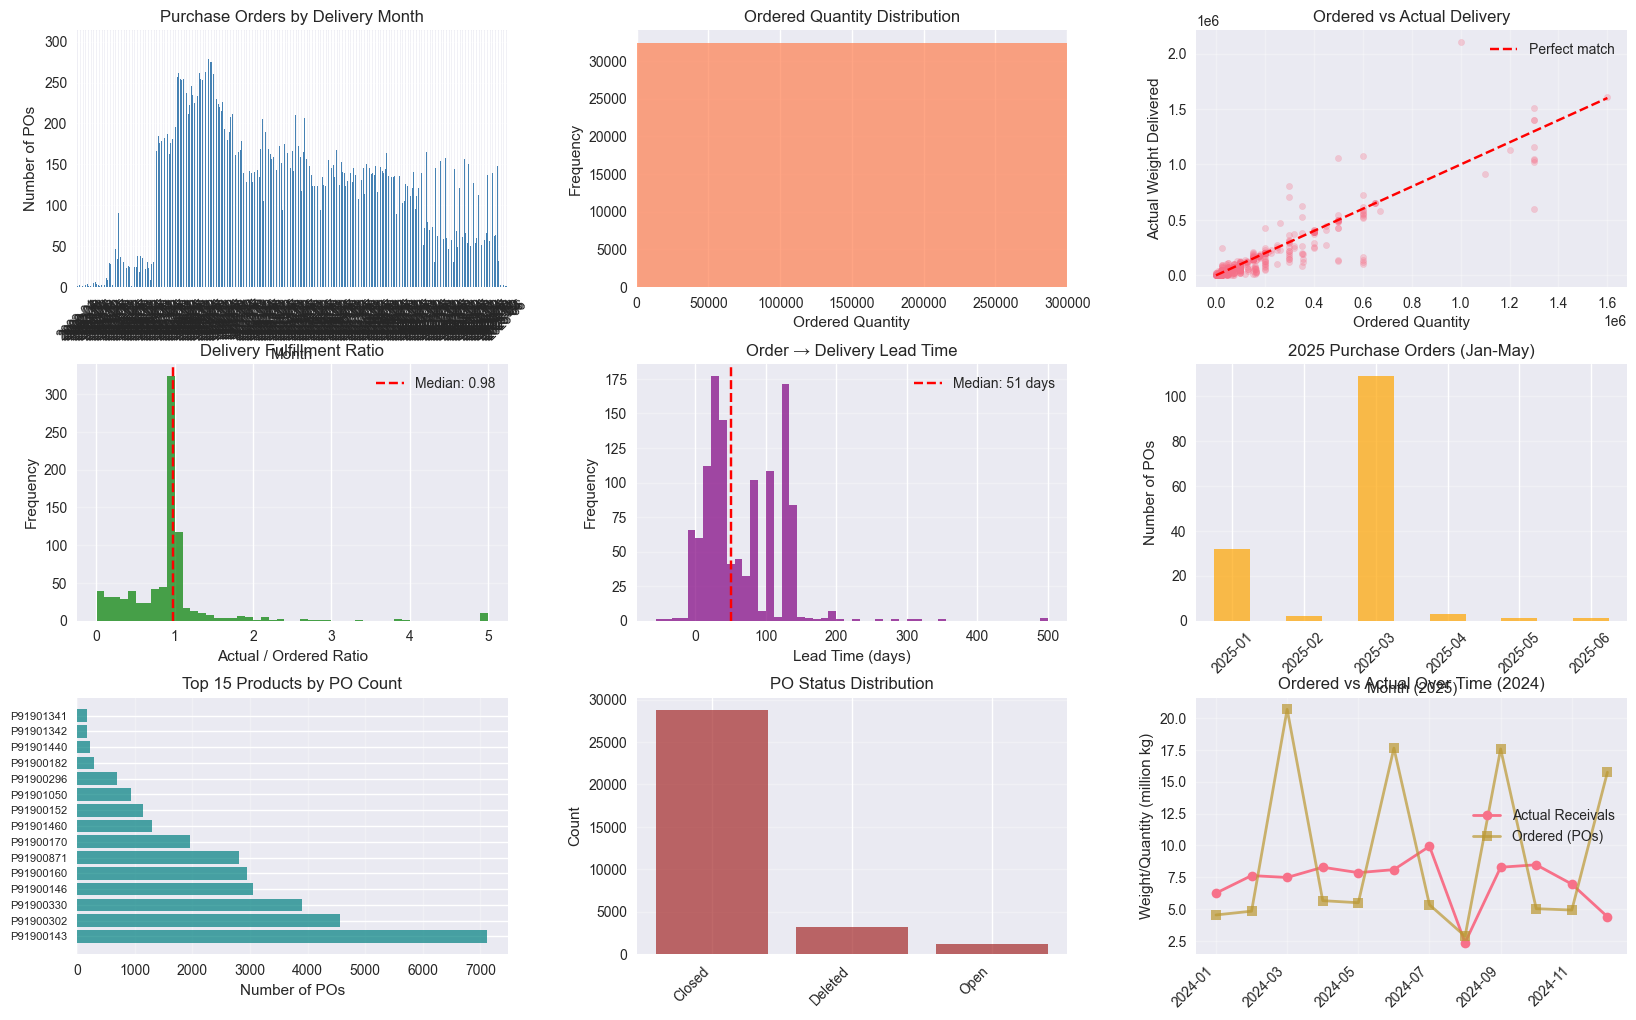

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load data
receivals = pd.read_csv('./Project_materials/data/kernel/receivals.csv')
purchase_orders = pd.read_csv('./Project_materials/data/kernel/purchase_orders.csv')
prediction_mapping = pd.read_csv('./Project_materials/data/prediction_mapping.csv')

# Convert dates
receivals['date_arrival'] = pd.to_datetime(receivals['date_arrival'], utc=True).dt.tz_localize(None)
purchase_orders['delivery_date'] = pd.to_datetime(purchase_orders['delivery_date'], utc=True).dt.tz_localize(None)
purchase_orders['created_date_time'] = pd.to_datetime(purchase_orders['created_date_time'], utc=True).dt.tz_localize(None)

receivals = receivals[receivals['net_weight'] > 0]
receivals = receivals[receivals['rm_id'].notna()]

print("="*80)
print("DEEP EDA: PURCHASE ORDERS - THE MISSING PIECE?")
print("="*80)

# ============================================================================
# HYPOTHESIS 1: Do purchase orders predict actual deliveries?
# ============================================================================
print("\n[1] PURCHASE ORDERS DATASET STRUCTURE")
print("-"*80)

print(f"Total purchase orders: {len(purchase_orders)}")
print(f"Columns: {purchase_orders.columns.tolist()}")
print(f"\nSample:")
print(purchase_orders.head(10).to_string())

print(f"\nDate ranges:")
print(f"  Created: {purchase_orders['created_date_time'].min()} to {purchase_orders['created_date_time'].max()}")
print(f"  Delivery: {purchase_orders['delivery_date'].min()} to {purchase_orders['delivery_date'].max()}")

print(f"\nUnique products: {purchase_orders['product_id'].nunique()}")
print(f"Unique purchase orders: {purchase_orders['purchase_order_id'].nunique()}")

# ============================================================================
# HYPOTHESIS 2: Coverage - which RMs have purchase orders?
# ============================================================================
print("\n[2] COVERAGE ANALYSIS")
print("-"*80)

# Merge receivals with POs to get rm_id
receivals_with_po = receivals.merge(
    purchase_orders[['purchase_order_id', 'purchase_order_item_no', 'product_id', 'quantity', 'delivery_date']],
    on=['purchase_order_id', 'purchase_order_item_no'],
    how='left'
)

print(f"Receivals: {len(receivals)}")
print(f"Receivals with PO match: {receivals_with_po['quantity'].notna().sum()} ({receivals_with_po['quantity'].notna().sum()/len(receivals)*100:.1f}%)")

# Test set coverage
test_rm_ids = prediction_mapping['rm_id'].unique()
test_receivals = receivals[receivals['rm_id'].isin(test_rm_ids)]
test_products = test_receivals['product_id'].unique()

pos_for_test_products = purchase_orders[purchase_orders['product_id'].isin(test_products)]
print(f"\nTest set analysis:")
print(f"  Test rm_ids: {len(test_rm_ids)}")
print(f"  Test products: {len(test_products)}")
print(f"  POs for test products: {len(pos_for_test_products)}")

# ============================================================================
# HYPOTHESIS 3: Do POs exist for 2025 (our forecast period)?
# ============================================================================
print("\n[3] CRITICAL: POs FOR 2025 FORECAST PERIOD")
print("-"*80)

pos_2024 = purchase_orders[purchase_orders['delivery_date'] >= '2024-01-01']
pos_2025 = purchase_orders[purchase_orders['delivery_date'] >= '2025-01-01']

print(f"POs with delivery in 2024: {len(pos_2024)}")
print(f"POs with delivery in 2025: {len(pos_2025)}")
print(f"POs with delivery in Jan-May 2025: {len(purchase_orders[(purchase_orders['delivery_date'] >= '2025-01-01') & (purchase_orders['delivery_date'] <= '2025-05-31')])}")

if len(pos_2025) > 0:
    print(f"\n✅ WE HAVE FUTURE PURCHASE ORDERS!")
    print(f"Sample 2025 POs:")
    print(pos_2025.head(10).to_string())
else:
    print(f"\n❌ NO PURCHASE ORDERS FOR 2025")

# ============================================================================
# HYPOTHESIS 4: Relationship between ordered quantity and actual delivery
# ============================================================================
print("\n[4] ORDERED QUANTITY vs ACTUAL DELIVERY")
print("-"*80)

# Match POs to receivals for 2024
analysis_data = []

for idx, po_row in purchase_orders[purchase_orders['delivery_date'] >= '2024-01-01'].iterrows():
    po_id = po_row['purchase_order_id']
    po_item = po_row['purchase_order_item_no']
    ordered_qty = po_row['quantity']
    delivery_date = po_row['delivery_date']
    product_id = po_row['product_id']
    
    # Find matching receivals
    matching_receivals = receivals[
        (receivals['purchase_order_id'] == po_id) &
        (receivals['purchase_order_item_no'] == po_item)
    ]
    
    if len(matching_receivals) > 0:
        actual_weight = matching_receivals['net_weight'].sum()
        rm_id = matching_receivals['rm_id'].iloc[0]
        
        analysis_data.append({
            'po_id': po_id,
            'product_id': product_id,
            'rm_id': rm_id,
            'ordered_qty': ordered_qty,
            'actual_weight': actual_weight,
            'delivery_date': delivery_date,
            'ratio': actual_weight / ordered_qty if ordered_qty > 0 else 0
        })

analysis_df = pd.DataFrame(analysis_data)

if len(analysis_df) > 0:
    print(f"Matched {len(analysis_df)} POs to actual deliveries")
    print(f"\nOrdered vs Actual statistics:")
    print(f"  Mean ordered: {analysis_df['ordered_qty'].mean():,.0f}")
    print(f"  Mean actual: {analysis_df['actual_weight'].mean():,.0f}")
    print(f"  Mean ratio (actual/ordered): {analysis_df['ratio'].mean():.3f}")
    print(f"  Median ratio: {analysis_df['ratio'].median():.3f}")
    
    print(f"\nRatio distribution:")
    print(analysis_df['ratio'].describe())
    
    # Correlation
    if len(analysis_df) > 10:
        corr = analysis_df[['ordered_qty', 'actual_weight']].corr().iloc[0, 1]
        print(f"\nCorrelation between ordered and actual: {corr:.3f}")

# ============================================================================
# HYPOTHESIS 5: Lead time analysis
# ============================================================================
print("\n[5] LEAD TIME ANALYSIS (Order → Delivery)")
print("-"*80)

# Calculate lead times
lead_time_data = []

for idx, po_row in purchase_orders[purchase_orders['delivery_date'] >= '2024-01-01'].iterrows():
    created = po_row['created_date_time']
    delivery = po_row['delivery_date']
    
    if pd.notna(created) and pd.notna(delivery):
        lead_time_days = (delivery - created).days
        lead_time_data.append({
            'lead_time_days': lead_time_days,
            'product_id': po_row['product_id'],
            'quantity': po_row['quantity']
        })

lead_time_df = pd.DataFrame(lead_time_data)

if len(lead_time_df) > 0:
    print(f"Lead time statistics (days):")
    print(lead_time_df['lead_time_days'].describe())
    print(f"\nTypical lead time: {lead_time_df['lead_time_days'].median():.0f} days")

# ============================================================================
# HYPOTHESIS 6: Can we use POs to predict test period?
# ============================================================================
print("\n[6] USING POs TO PREDICT TEST PERIOD (JAN-MAY 2025)")
print("-"*80)

# Get POs with delivery in our test period
test_period_pos = purchase_orders[
    (purchase_orders['delivery_date'] >= '2025-01-01') &
    (purchase_orders['delivery_date'] <= '2025-05-31')
]

print(f"POs with delivery in Jan-May 2025: {len(test_period_pos)}")

if len(test_period_pos) > 0:
    print(f"\nProducts in test period POs:")
    print(test_period_pos['product_id'].value_counts().head(10))
    
    # Can we map these to rm_ids?
    test_products_in_pos = test_period_pos['product_id'].unique()
    
    # Find which rm_ids use these products
    rm_product_mapping = receivals.groupby('product_id')['rm_id'].unique().to_dict()
    
    predicted_rms = set()
    for product in test_products_in_pos:
        if product in rm_product_mapping:
            predicted_rms.update(rm_product_mapping[product])
    
    print(f"\nRMs that might receive based on POs: {len(predicted_rms)}")
    print(f"Test RMs: {len(test_rm_ids)}")
    print(f"Coverage: {len(predicted_rms.intersection(test_rm_ids))}/{len(test_rm_ids)} ({len(predicted_rms.intersection(test_rm_ids))/len(test_rm_ids)*100:.1f}%)")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n[7] CREATING VISUALIZATIONS")
print("-"*80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: PO timeline
ax1 = fig.add_subplot(gs[0, 0])
po_by_month = purchase_orders.groupby(purchase_orders['delivery_date'].dt.to_period('M')).size()
if len(po_by_month) > 0:
    po_by_month.plot(kind='bar', ax=ax1, color='steelblue')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Number of POs')
    ax1.set_title('Purchase Orders by Delivery Month')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(alpha=0.3, axis='y')

# Plot 2: Ordered quantity distribution
ax2 = fig.add_subplot(gs[0, 1])
if len(purchase_orders[purchase_orders['quantity'] > 0]) > 0:
    ax2.hist(purchase_orders[purchase_orders['quantity'] > 0]['quantity'], bins=50, color='coral', alpha=0.7)
    ax2.set_xlabel('Ordered Quantity')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Ordered Quantity Distribution')
    ax2.set_xlim(0, purchase_orders['quantity'].quantile(0.95))
    ax2.grid(alpha=0.3, axis='y')

# Plot 3: Ordered vs Actual scatter
ax3 = fig.add_subplot(gs[0, 2])
if len(analysis_df) > 0:
    sample = analysis_df.sample(min(1000, len(analysis_df)))
    ax3.scatter(sample['ordered_qty'], sample['actual_weight'], alpha=0.3, s=20)
    ax3.plot([0, sample['ordered_qty'].max()], [0, sample['ordered_qty'].max()], 'r--', label='Perfect match')
    ax3.set_xlabel('Ordered Quantity')
    ax3.set_ylabel('Actual Weight Delivered')
    ax3.set_title('Ordered vs Actual Delivery')
    ax3.legend()
    ax3.grid(alpha=0.3)

# Plot 4: Ratio distribution
ax4 = fig.add_subplot(gs[1, 0])
if len(analysis_df) > 0:
    ax4.hist(analysis_df['ratio'].clip(0, 5), bins=50, color='green', alpha=0.7)
    ax4.axvline(analysis_df['ratio'].median(), color='red', linestyle='--', label=f'Median: {analysis_df["ratio"].median():.2f}')
    ax4.set_xlabel('Actual / Ordered Ratio')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Delivery Fulfillment Ratio')
    ax4.legend()
    ax4.grid(alpha=0.3, axis='y')

# Plot 5: Lead time distribution
ax5 = fig.add_subplot(gs[1, 1])
if len(lead_time_df) > 0:
    ax5.hist(lead_time_df['lead_time_days'].clip(-100, 500), bins=50, color='purple', alpha=0.7)
    ax5.axvline(lead_time_df['lead_time_days'].median(), color='red', linestyle='--', label=f'Median: {lead_time_df["lead_time_days"].median():.0f} days')
    ax5.set_xlabel('Lead Time (days)')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Order → Delivery Lead Time')
    ax5.legend()
    ax5.grid(alpha=0.3, axis='y')

# Plot 6: 2025 POs by month
ax6 = fig.add_subplot(gs[1, 2])
if len(pos_2025) > 0:
    pos_2025_by_month = pos_2025.groupby(pos_2025['delivery_date'].dt.to_period('M')).size()
    pos_2025_by_month.plot(kind='bar', ax=ax6, color='orange', alpha=0.7)
    ax6.set_xlabel('Month (2025)')
    ax6.set_ylabel('Number of POs')
    ax6.set_title('2025 Purchase Orders (Jan-May)')
    ax6.tick_params(axis='x', rotation=45)
    ax6.grid(alpha=0.3, axis='y')

# Plot 7: Product coverage
ax7 = fig.add_subplot(gs[2, 0])
top_products_po = purchase_orders['product_id'].value_counts().head(15)
ax7.barh(range(len(top_products_po)), top_products_po.values, color='teal', alpha=0.7)
ax7.set_yticks(range(len(top_products_po)))
ax7.set_yticklabels([f"P{int(p)}" for p in top_products_po.index], fontsize=8)
ax7.set_xlabel('Number of POs')
ax7.set_title('Top 15 Products by PO Count')
ax7.grid(alpha=0.3, axis='x')

# Plot 8: Status distribution
ax8 = fig.add_subplot(gs[2, 1])
status_counts = purchase_orders['status'].value_counts()
ax8.bar(range(len(status_counts)), status_counts.values, color='brown', alpha=0.7)
ax8.set_xticks(range(len(status_counts)))
ax8.set_xticklabels(status_counts.index, rotation=45, ha='right')
ax8.set_ylabel('Count')
ax8.set_title('PO Status Distribution')
ax8.grid(alpha=0.3, axis='y')

# Plot 9: Timeline comparison
ax9 = fig.add_subplot(gs[2, 2])
# Receivals timeline
receivals_2024 = receivals[receivals['date_arrival'] >= '2024-01-01']
receivals_by_month = receivals_2024.groupby(receivals_2024['date_arrival'].dt.to_period('M'))['net_weight'].sum() / 1e6
po_2024 = purchase_orders[purchase_orders['delivery_date'] >= '2024-01-01']
po_by_month_qty = po_2024.groupby(po_2024['delivery_date'].dt.to_period('M'))['quantity'].sum() / 1e6

if len(receivals_by_month) > 0 and len(po_by_month_qty) > 0:
    months = receivals_by_month.index.astype(str)
    x = range(len(months))
    ax9.plot(x, receivals_by_month.values, marker='o', label='Actual Receivals', linewidth=2)
    ax9.plot(x, po_by_month_qty.values[:len(x)], marker='s', label='Ordered (POs)', linewidth=2, alpha=0.7)
    ax9.set_xticks(x[::2])
    ax9.set_xticklabels(months[::2], rotation=45, ha='right')
    ax9.set_ylabel('Weight/Quantity (million kg)')
    ax9.set_title('Ordered vs Actual Over Time (2024)')
    ax9.legend()
    ax9.grid(alpha=0.3)

plt.savefig('purchase_orders_deep_eda.png', dpi=300, bbox_inches='tight')
print("Saved to 'purchase_orders_deep_eda.png'")

# ============================================================================
# KEY FINDINGS
# ============================================================================
print("\n" + "="*80)
print("KEY FINDINGS: CAN WE USE PURCHASE ORDERS?")
print("="*80)

findings = []

# Finding 1: Do we have 2025 POs?
if len(pos_2025) > 0:
    findings.append(f"✅ We have {len(test_period_pos)} POs for Jan-May 2025")
    findings.append(f"   This is FORWARD-LOOKING information!")
else:
    findings.append(f"❌ No POs for 2025 - cannot use for prediction")

# Finding 2: Correlation
if len(analysis_df) > 0:
    corr = analysis_df[['ordered_qty', 'actual_weight']].corr().iloc[0, 1] if len(analysis_df) > 1 else 0
    findings.append(f"📊 Ordered vs Actual correlation: {corr:.3f}")
    if corr > 0.7:
        findings.append(f"   ✅ Strong correlation - PO quantity predicts actual!")
    elif corr > 0.4:
        findings.append(f"   ⚠️  Moderate correlation - some predictive power")
    else:
        findings.append(f"   ❌ Weak correlation - POs don't predict well")

# Finding 3: Coverage
if len(test_period_pos) > 0 and len(predicted_rms) > 0:
    coverage_pct = len(predicted_rms.intersection(test_rm_ids))/len(test_rm_ids)*100
    findings.append(f"📍 PO coverage of test RMs: {coverage_pct:.1f}%")
    if coverage_pct > 50:
        findings.append(f"   ✅ Good coverage - can help predictions")
    else:
        findings.append(f"   ⚠️  Limited coverage")

print("\n")
for i, finding in enumerate(findings, 1):
    print(f"{i}. {finding}")

print("\n" + "="*80)
print("RECOMMENDATION")
print("="*80)

if len(pos_2025) > 0 and len(analysis_df) > 0:
    corr = analysis_df[['ordered_qty', 'actual_weight']].corr().iloc[0, 1] if len(analysis_df) > 1 else 0
    if corr > 0.4:
        print("""
✅ PURCHASE ORDERS CAN HELP!

Recommended features to add:
1. total_ordered_in_horizon: Sum of PO quantities for forecast period
2. num_pos_in_horizon: Count of POs expected
3. has_future_po: Binary flag if any PO exists
4. avg_po_quantity: Historical average PO size per RM

This is FORWARD-LOOKING data that could break through to <5,000!
""")
    else:
        print("""
⚠️  Purchase orders have weak correlation with actual deliveries.
Might not help much, but worth trying as a last resort.
""")
else:
    print("""
❌ Cannot use purchase orders effectively:
- Either no 2025 POs exist, or
- Correlation too weak to be useful
""")

print("="*80)